In [1]:
import ee
service_account = 'renosterveld-ee@ee-vegetation-gee4geo.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'ee-vegetation-gee4geo-6309a79ef209.json')
ee.Initialize(credentials)

In [2]:
import tensorflow as tf
import json
from eoflow.models import TransformerEncoder, TempCNNModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from utils.tf_data_utils import *
from utils.globals import *

/home/jupyter/.local/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
with open('data/max.json') as f:
  Max = json.load(f)

with open('data/min.json') as f:
  Min = json.load(f)

In [4]:
trainFilePath = 'data/Training_reno_cnn.tfrecord.gz'
testFilePath = 'data/Testing_reno_cnn.tfrecord.gz'
validFilePath = 'data/Valid_reno_cnn.tfrecord.gz'

In [5]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[tsLength], dtype=tf.float32) 
    for k in featureNames
]
# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

# plot time

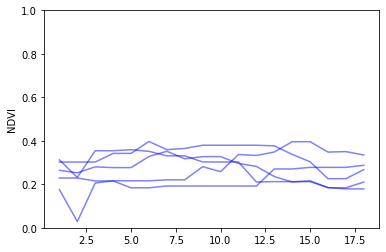

In [7]:
dataset0 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn0)

y = iter(dataset0.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

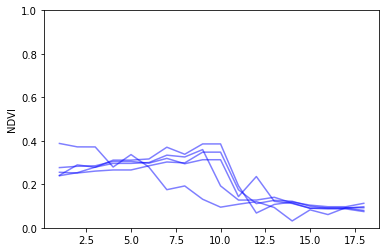

In [8]:
dataset1 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn1)

y = iter(dataset1.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

# data

In [6]:
dataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.shuffle(buffer_size=buff, seed=42)\
.repeat()\
.batch(batch_size)

In [7]:
valDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

## CNN

In [ ]:
#model pars
model_cfg = {
    "learning_rate": lr,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "metrics": ["accuracy","precision","recall"],
    "loss": "focal_loss",
    "kernel_regularizer": 1e-08,
    "nb_conv_filters": 32,
    "nb_conv_stacks": 3
}

# rubn model
model_cnn = TempCNNModel(model_cfg)
model_cnn.build(input_shape)
model_cnn.prepare()
model_cnn.train_and_evaluate(
    train_dataset=dataset,
    val_dataset=valDataset,
    num_epochs=epochs,
    iterations_per_epoch=steps,
    model_directory=model_directory,
    save_steps='epoch',
    summary_steps='epoch',
    verbose=0
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 18)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 32)            2912      
_________________________________________________________________
activation (Activation)      (None, 18, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 32)            5152      
_________________________________________________________________
activation_1 (Activation)    (None, 18, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 32)            0     

## Transformer

In [12]:
#model pars
model_cfg = {
    "learning_rate": lr/2,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "metrics": ["accuracy","precision","recall"],
    "loss": "focal_loss",
    "num_heads": 4,
    "num_layers": 2,
    "d_model": 128,
    "layer_norm": False,
    "num_dff":256
}

# rubn model
model_trans = TransformerEncoder(model_cfg)
model_trans.build(input_shape)
model_trans.prepare()
model_trans.train_and_evaluate(
    train_dataset=dataset,
    val_dataset=valDataset,
    num_epochs=epochs,
    iterations_per_epoch=steps,
    model_directory=model_directory,
    save_steps='epoch',
    summary_steps='epoch',
    verbose=0
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            (None, 18, 128)           267392    
_________________________________________________________________
dense_14 (Dense)             (None, 18, 2)             258       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 2)              0         
_________________________________________________________________
squeeze (Lambda)             (None, 2)                 0         
_________________________________________________________________
softmax_1 (Softmax)          (None, 2)                 0         
Total params: 267,650
Trainable params: 267,650
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                

KeyboardInterrupt: 

## Random Forest

In [13]:
dataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

valDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

tlab = list(dataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
trainy=list(tlab)

tdat = list(dataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
trainx=list(tdat)

vallab = list(valDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
valy=list(vallab)

valdat = list(valDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
valx=list(valdat)

labelval = np.vstack(valy)
labelval = np.argmax(labelval,axis=1)

xval = np.vstack(valx)
xval = np.transpose(xval, (0, 2, 1))
xval_flat = xval.reshape(xval.shape[0],(xval.shape[1]*xval.shape[2]))

labeltr = np.vstack(trainy)
labeltr = np.argmax(labeltr,axis=1)

xtr = np.vstack(trainx)
xtr = np.transpose(xtr, (0, 2, 1))
xtr_flat = xtr.reshape(xtr.shape[0],(xtr.shape[1]*xtr.shape[2]))

rf_data = (xtr_flat,labeltr,xval_flat,labelval)

model_rf = RandomForestClassifier(n_estimators = 100, max_features = 'auto', min_samples_split = 4, random_state = 42)
model_rf.fit(rf_data[0], rf_data[1])
y_pred = model_rf.predict(rf_data[2])
result = metrics.f1_score(rf_data[3],y_pred)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
result

# test data

In [26]:
# List of fixed-length features, all of which are float32.
testcolumns = [
  tf.io.FixedLenFeature(shape=[testLength], dtype=tf.float32) 
    for k in testNames
]
# Dictionary with names as keys, features as values.
testfeaturesDict = dict(zip(testNames, testcolumns))

In [27]:
testDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: popkey(x,['ndvi_diff','roll','count']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

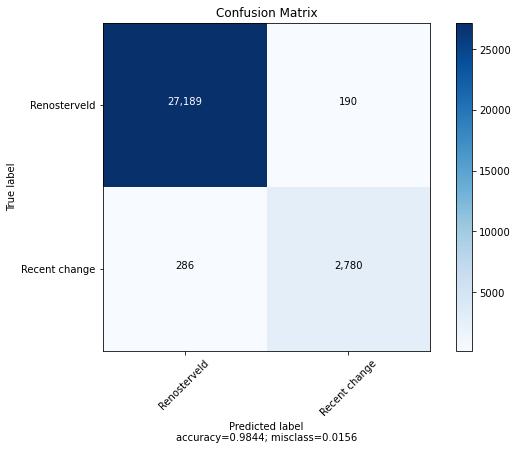

In [28]:
predictions = model_cnn.predict(testDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [ ]:
result = metrics.f1_score(y_obs,pred_y)

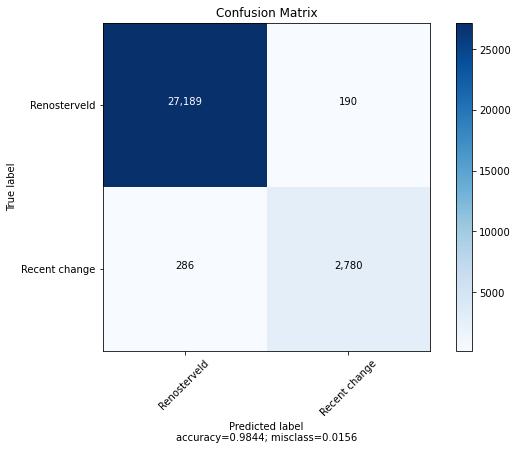

In [28]:
predictions = model_trans.predict(testDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [ ]:
result = metrics.f1_score(y_obs,pred_y)

In [32]:
pred_y =  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.map(lambda x: labeller(x, 'roll'))\
.filter(filter_fn)\
.map(lambda x: poplabint(x, 'roll'))\
.batch(batch_size)\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

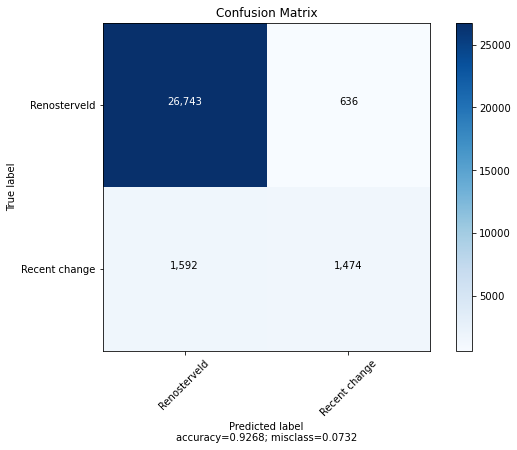

In [33]:
pred_y = list(pred_y)
pred_y = np.vstack(pred_y)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [ ]:
testDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: popkey(x,['ndvi_diff','roll','count']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

vallab = list(testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
valy=list(vallab)

valdat = list(testDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
valx=list(valdat)

labelval = np.vstack(valy)
labelval = np.argmax(labelval,axis=1)

xval = np.vstack(valx)
xval = np.transpose(xval, (0, 2, 1))
xval_flat = xval.reshape(xval.shape[0],(xval.shape[1]*xval.shape[2]))

rf_data = (xval_flat,labelval)

y_pred = model_rf.predict(rf_data[0])
result = metrics.f1_score(rf_data[1],y_pred)

In [ ]:
con_mat = tf.math.confusion_matrix(labels=labelval, predictions=y_pred).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")